# Методы высокого порядка

In [1]:
from utils.config import *
from utils.graphics import *

### 1. Реализовать методы Gauss-Newton и Powell Dog Leg для решения нелинейной регрессии
Сравниить эффективность с методами, реализованными в предыдущих работах.

---

_ну видимо надо скопировать какие-нибудь методы из прошлой работы. предлагаю взять scaling с прикрученным adam'ом_

что на почитать:
* [метод нелинейных наименьших квадратов](https://studopedia.ru/13_84158_nelineyniy-metod-naimenshih-kvadratov.html)
* [метод гаусса-ньютона](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%93%D0%B0%D1%83%D1%81%D1%81%D0%B0_%E2%80%94_%D0%9D%D1%8C%D1%8E%D1%82%D0%BE%D0%BD%D0%B0)
* [разница между якобианом и гессианом](http://www.machinelearning.ru/wiki/index.php?title=%D0%92%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86_%D0%AF%D0%BA%D0%BE%D0%B1%D0%B8_%D0%B8_%D0%93%D0%B5%D1%81%D1%81%D0%B5)

---

### Метод Гаусса-Ньютона, теория.

В отличие от метода Ньютона, алгоритм Гаусса — Ньютона может быть использован только для минимизации суммы квадратов, но его преимущество в том, что метод не требует вычисления вторых производных.

Здесь и далее m - количество точек для аппроксимации, n - размерность задачи и $m \geq n$ (важно, так как сломается обратимость матрицы из-за неоднозначного решения уравнений).

Функция ошибки записывается вот так: $\displaystyle f(x) = \sum_{i=1}^{m} r_i(x)^2$, где $r_i(\beta) = y_i - F(x_i, \beta)$. Ее градиент равен $\displaystyle \nabla f(x) = 2 \sum_{i=1}^{m} r_i(x) \cdot \nabla r_i$.

Тогда каждая компонента равна $\displaystyle \frac{\partial f}{\partial x_j} = 2 \sum_{i=1}^{m} r_i(x) \cdot \frac{\partial r_i(x)}{\partial x_j}$, а весь градиент в матричной нотации $\nabla f = 2 \cdot \mathfrak{J}^T \cdot r$.

Кажется, что $\mathfrak{J}$ - это якобиан. Каждый компонент этой матрицы равен $\displaystyle  \mathfrak{J}_{ij} = \frac{\partial r_i}{\partial x_j}$.

Тогда $r$ - матрица из $r_i$.

Компонента гессиана (матрицы вторых производных) вычисляется так: $\displaystyle H_{jk} = 2 \sum_{i=1}^{m}(\frac{\partial r_i}{\partial x_j} \frac{\partial r_i}{\partial x_k} + r_i \frac{\partial^2 r_i}{\partial x_j \partial x_k})$

Метод Гаусса-Ньютона игнорирует второе слагаемое в скобке под знаком суммы, предполагая, что оно много меньше первого. В этом отличие данного метода от BFGS, который пытается это слагаемое аппроксимировать с помощью первых производных. Пока что рассмотрим именно теорию метода Гаусса-Ньютона.

Приближенный компонент гессиана: $\displaystyle H_{jk} \approx 2 \sum_{i=1}^{m} \mathfrak{J}_{ij} \cdot \mathfrak{J}_{ik}$

Тогда неточный гессиан равен $H \approx 2 \cdot \mathfrak{J}^T \cdot \mathfrak{J}$

Вспомним, что метод Гаусса-Ньютона основан на методе Ньютона. В последнем каждый следующий шаг вычислялся по формуле:

$\displaystyle x_{k+1} = x_k - \frac{\alpha}{H} \cdot \nabla f(x_k)$

Имея на руках градиент и приближенный гессиан, можем записать формулу следующего шага в рассматриваемом методе:

$\displaystyle x_{k+1} = x_k - \frac{\alpha}{\mathfrak{J}^T \cdot \mathfrak{J}} \cdot \mathfrak{J}^T \cdot r (x_k)$

В методе Гаусса-Ньютона можно использовать условия Вольфе. Можно показать примером, что условие малости вторых производных существенно.

_Примечание_:

Если записать рекуррентную формулу шага как $x_{k+1} = x_k + \alpha \cdot p$, то $P$ можно находить, решая СЛАУ:

$(\mathfrak{J}^T \cdot \mathfrak{J}) \cdot P = - \mathfrak{J}^T \cdot r$




In [2]:
# общий код градиентного спуска

def XStopCondFactory(eps=EPS):
    return lambda prev_x, x, **kwargs: sum(np.sqrt(np.abs(x - prev_x))) < eps

def DontStop():
    return lambda **kwargs: False

def regression(mover, x0, stop_cond=XStopCondFactory(), max_epochs=1000):
    assert type(x0) == np.ndarray, "x0 point should have np.ndarray type"

    points = np.array([x0.copy()])
    epoch = 1
    x = x0.copy()
    prev_x = None

    while (prev_x is None or not stop_cond(prev_x=prev_x, x=x, epoch=epoch)) and epoch <= max_epochs:
        prev_x = x.copy()
        x = mover(x, epoch=epoch, max_epochs=max_epochs)
        points = np.concatenate([points, [x.copy()]])
        epoch += 1
    return points


In [3]:
# код метода гаусс-ньютона.

# здесь и далее тип point задан так: p = [y, x_1, x_2, ... x_n]
# все функции градиента должны возвращать тип np.ndarray и причем как столбец!
# все иксы тем не менее хотим ради удобства передавать в муверы/regression как вектор-строку.
# мы должны учитывать что входящий икс всегда вектор-строка и как-то внутри это конвертить.

from functions.LeastSquaresMethod import *

class GaussNewtonMover:
    function = None
    lr = None

    def __init__(self, function, lr):
        assert isinstance(function, LeastSquaresMethod),\
            "ахтунг, гаусс-ньютон умеет только в решение задачи минимизации суммы квадратов"
        self.function = function
        self.lr = lr
    
    def get_error(self, c):
        return self.function.get_error(c)

    def __call__(self, x, **kwargs):
        g = self.function.grad(x)
        h = self.function.hessian(x)
        p = np.matmul(np.linalg.inv(h), g)
        return (x.reshape(-1, 1) - self.lr * p).T[0] # внимание тут дважды транспонирование икса
    
    def get_stop_cond(self, eps=1e-8):
        return lambda x, **kwargs: self.get_error(x) < eps


#### Пример применения Гаусс-Ньютона 1.

Аппроксимация параболы по трем точкам. Этого достаточно, чтобы определить параболу целиком.

Исходная функция: $0.005x^2 + 0.5x + 10$

In [4]:
import functions.Polynomial as poly

parabola_points = [(10, 0), (-2.5, -50), (10, -100)]

def parabola_approx(mover, c=np.zeros(3), stats=True, points=False):
    regr = regression(mover, c, mover.get_stop_cond())
    if stats:
        print("result", regr[-1])
        print("iterations", len(regr) - 1)
        print("error", mover.function.f(regr[-1]))
    if points:
        return regr


def parabola_gn():
    return GaussNewtonMover(LeastSquaresMethod(parabola_points, poly), 0.91)


parabola_approx(parabola_gn())

result [4.99997048e-03 4.99997048e-01 9.99994095e+00]
iterations 5
error 3.4867844010891475e-09


#### Пример применения Гаусс-Ньютона 2.

Аппроксимация многочлена пятой степени по семи точкам.

Исходная функция: $0.0005x^5 - 0.4x^4 + 2x^3 + 1x^2 - 10x + 10$

In [5]:
polynomial_points = [
    (0, -2.37088), # потеря точности
    (11.584, -2),
    (19.178, -1.2497),
    (10, 0),
    (1.9123, 1.381),
    (13.406, 3.643),
    (0, 4.65926)
    ]

def polynomial_approx(mover, c=np.zeros(6), stats=True, points=False):
    regr = regression(mover, c, mover.get_stop_cond())
    if stats:
        print("result", regr[-1])
        print("iterations", len(regr) - 1)
        print("error", mover.function.f(regr[-1]))
    if points:
        return regr


def polynomial_gn():
    return GaussNewtonMover(LeastSquaresMethod(polynomial_points, poly), 1)


polynomial_approx(polynomial_gn())

result [ 4.97899579e-04 -3.99992891e-01  2.00001921e+00  9.99979189e-01
 -1.00000062e+01  9.99995471e+00]
iterations 1
error 1.6180908869279155e-09


OK, Гаусс-Ньютон реализован и работает, приступим к Powell's Dog Leg.

---

на почитать про DogLeg

* [comprehensive статья на хабре](https://habr.com/ru/post/335224/)


---

### Метод Dog Leg, теория.

Метод Dog Leg реализует стратегию доверительного региона (trust-region) на квадратичной модели. Модель пытается описать функцию, которую мы хотим минимизировать. **Важное замечание**: это общий метод минимизации функций, а не только метод решения задачи минимизации квадратных отклонений. То есть он круче Гаусса-Ньютона.

Выглядит модель так: $m_k(p) = f(x_k) + \nabla f(x_k)^T p + \frac{1}{2} \cdot p^T H p$ _(да это ряд тейлора на самом деле)_

Что хотим: $\displaystyle \min_{\|p\| \leq \Delta_k} m(p)$, где $\Delta_k$ - радиус доверительного региона.

Примечательно, что на википедии написано, что положительная определенность матрицы Гессе (H, матрица вторых производных) является условием локального минимума функции. ~~Но вообще-то мы это в третьем семестре матана проходили~~.

Что такое доверительный регион? Это сфера, в которой мы уверены, что наша квадратичная модель хорошо описывает функцию. Если мы в пределах нашего региона пойдем в сторону минимума по градиенту, мы его должны найти. Метод Dog Leg умеет управлять радиусом доверительного региона - сужать или расширять его. Выбор, что делать, основывается на сходстве функции $m_k$ и целевой функции $f$ на предыдущей итерации. После нахождения $p_k$ (решение модели - шаг в сторону минимизации) мы определяем следующее соотношение:

$\displaystyle \rho_k = \frac{f(x_k) - f(x_k + p_k)}{m_k(0) - m_k(p_k)}$ (да, $\rho_k$ и $p_k$ - это разные буквы)

Если все делать правильно, то знаменатель никогда не должен быть отрицательным (ну мы же минимизируем нашу модель).

Дальше, если

* $\rho_k < 0$ или $\rho_k \approx 0$ - уменьшаем радиус доверительного региона.
* $\rho_k \approx 1$ - тогда модель хорошо соответствует целевой функции - расширяем trust-region.
* иначе, ничего не делаем

#### Запишем в краткой форме обновление trust-region части алгоритма DogLeg.

Пусть на текущей итерации $k$ имеем на руках решение $p_k$ минимума модели $m_k$ с радиусом доверительного региона $\Delta_k$ и степенью сходства модели и функции $\rho_k$, тогда радиус доверительного региона $\Delta_{k+1}$ на следующей итерации равен:

\begin{cases}
\Delta_{k+1} = \frac{1}{4} \Delta_k & \text{$\rho_k < \frac{1}{4}$} \\
\Delta_{k+1} = \min(2 \Delta_k, \Delta_{max}) & \text{$\rho_k > \frac{3}{4} \; and \; \|p_k\| == \Delta_k$} \\
\Delta_{k+1} = \Delta_k & \text{otherwise}
\end{cases}

И следующая точка вычисляется так:

\begin{cases}
x_{k+1} = x_k + p_k & \text{$if \; \rho_k > \eta, \; where \; \eta \in [0, \frac{1}{4})$} \\
x_{k+1} = x_k & \text{otherwise}
\end{cases}

#### Теперь о том, как решить модель и найти $p_k$.

Когда $\Delta_k$ весьма мало, то ограничение доверительного региона гарантирует, что квадратный член модели $m_k$ оказывает небольшое влияние на решение, тогда решим линейную:

$\displaystyle p^*(\Delta) \approx -\Delta \frac{\nabla f}{\| \nabla f \|}$

Вопрос: что это такое? Мы берем вектор, по которому хотим пройти (в сторону антиградиента), нормируем его, и умножаем на радиус нашей сферы доверительного региона. Нам же выгодно пройти как можно дальше в сторону минимума, но не дальше, чем радиус нашей сферы!

Но для средних значений $\Delta$ решение $p^*(\Delta)$, как правило, следует за криволинейной траекторией, как показано на картинке. То есть к решению линейной части постепенно подмешивается квадратичная. Шагать так мы не умеем.


![dogleg method descent](../data/dogleg.png)

Метод Dogleg аппроксимирует криволинейную траекторию двумя векторами.

**Первый** простирается вдоль направления наискорейшего спуска (это как градиентный спуск, только learning rate не нужен - он здесь вычисляется оптимальным образом, _вроде_):

$\displaystyle p^U = - \frac{\nabla f^T \nabla f}{\nabla f^T H \nabla f} \nabla f$

Вопрос: а это что блин такое?

> Метод Гаусса-Ньютона и метод Dogleg опираются на одну и ту же квадратичную модель. Можно записать условие минимума этой модели от точки $x + \alpha \cdot p$. Условие минимума очевидно - там градиент должен быть равен нулю. Тогда как найти такое $\alpha$, чтобы туда сразу шагнуть и чтоб стало хорошо:
> 
> $\displaystyle \alpha = \frac{-\nabla f(x)^T \cdot p}{p^T \cdot \nabla^2 f(x) \cdot p}$
> 
> $p$ - это направление движения. Давайте подставим вместо $p$ градиент $\nabla f(x)$
> 
> Тогда $\displaystyle \alpha \cdot p = \frac{-\nabla f(x)^T \cdot \nabla f(x)}{\nabla f(x)^T \cdot \nabla^2 f(x) \cdot \nabla f(x)} \nabla f(x)$ = 
> $\displaystyle - \frac{\nabla f^T \nabla f}{\nabla f^T H \nabla f} \nabla f$

**Второй** вектор $p^H$ = $\displaystyle - \frac{\nabla f}{H}$. Это решение для минимума квадратичной модели за один шаг. Посчитан должен быть также из точки $p_k$.

Не забываем о том, что мы не должны выходить за сферу доверительного региона.

#### Суммируя, получаем алгоритм шага:

* Если $p^U$ пересекает сферу, ищем точку пересечения и шагаем в нее (здесь, наверное, к тому, что $\Delta_k$ мал)

* Пробуем шагнуть $p^H$, если $p^H \in$ trust-region

* Иначе утверждается, что $p^U + \tau (p^H - p^U)$ точно пересекает сферу. Найдем точку пересечения и шагнем в нее.

_Примечание: матрица Гессе может быть как точной, так и неточной._

_Примечание: в этом методе нигде не используется learning rate_

#### Научимся вычислять точку пересечения из третьего случая.

Обозначим $A = p^U, \; B = p^H - p^U$ (уменьшается влияние линейной части и возрастает квадратичной).

$\| A + \tau \cdot B \|^2 = tr^2$

$(A + \tau \cdot B)^T (A + \tau \cdot B) = tr^2$

$(A + \tau \cdot B)^T A + \tau (A + \tau \cdot B)^T B = tr^2$

$A^T A + \tau B^T A + \tau A^T B + \tau^2 B^T B = tr^2$

$\tau^2(B^T B) + \tau(2 \cdot A^T B) + A^T A - tr^2 = 0$

Получили квадратное уравнение.

$\sqrt{\frac{D}{4}} = \sqrt{(A^T B)^2 - (B^T B)(A^T A - tr^2)}$

Заметим, что разность под корнем всегда будет суммой при наших условиях. Второе замечание: $\sqrt{\frac{D}{4}} > (A^T B)$

$\displaystyle T = \frac{-A^T B + \sqrt{\frac{D}{4}}}{B^T B}$

Да, берем дискриминант с положительным знаком, чтобы коэффициент $\tau$ был положительным. В общем-то, все.




In [6]:
# код метода Powell's DogLeg (или как говорят, метод собачьей лапки Пауэла)

class DogLegMover:
    function = None
    max_tr = None
    tr = None
    eta = None

    def __init__(self, function, initial_tr=1.0, max_tr=100.0, eta=0.15):
        assert initial_tr <= max_tr, "initial_tr must be <= than max_tr"
        self.function = function
        self.tr = initial_tr
        self.max_tr = max_tr
        self.eta = eta

    def make_step(self, g, h):
        # steppest descent direction
        pU = -(np.matmul(g.T, g) / np.matmul(g.T, np.dot(h, g))) * g
        pU_norm = np.linalg.norm(pU)

        # case 1
        if pU_norm >= self.tr:
            return self.tr * pU / pU_norm
        
        # direction to global minimum of quadratic model
        pH = -np.matmul(np.linalg.inv(h), g)
        pH_norm = np.linalg.norm(pH)

        # case 2
        if pH_norm <= self.tr:
            return pH
        
        # case 3
        A = pU
        B = pH - pU
        discriminant = np.matmul(A.T, B)**2 - np.matmul(B.T, B) * (np.matmul(A.T, A) - self.tr**2)
        tau = (-np.matmul(A.T, B) + np.sqrt(discriminant)) / np.matmul(B.T, B)

        return A + tau * B

    def __call__(self, x, **kwargs):
        g = self.function.grad(x)
        h = self.function.hessian(x)
        self.prev_g = g # store gradient to use in stop cond

        # Get direction
        p = self.make_step(g, h)

        # Actual reduction
        act_red = self.function.f(x) - self.function.f((x + p.T)[0])
        
        # Predicted reduction
        pred_red = -(np.matmul(g.T, p) + 0.5 * np.matmul(p.T, np.dot(h, p)))
        
        # Calc rho
        if pred_red == 0.0:
            rho = 1e99
        else:
            rho = act_red / pred_red
        
        # Change tr
        if rho < 0.25:
            self.tr = 0.25 * self.tr
        elif rho > 0.75 and np.abs(np.linalg.norm(p) - self.tr) < 1e-9:
            self.tr = min(2.0 * self.tr, self.max_tr)

        # Choose the position for the next iteration.
        if rho > self.eta:
            return (x + p.T)[0]
        else:
            return x
    
    def get_stop_cond(self, eps=EPS):
        return lambda **kwargs: self.prev_g is not None and np.linalg.norm(self.prev_g) < eps



#### Проверка метода на функции Розенброка (a=1, b=100).

Исходная функция: $(1 - x)^2 + 100(y - x^2)^2$

Минимум достигается в точке (1, 1), где функция равна нулю.

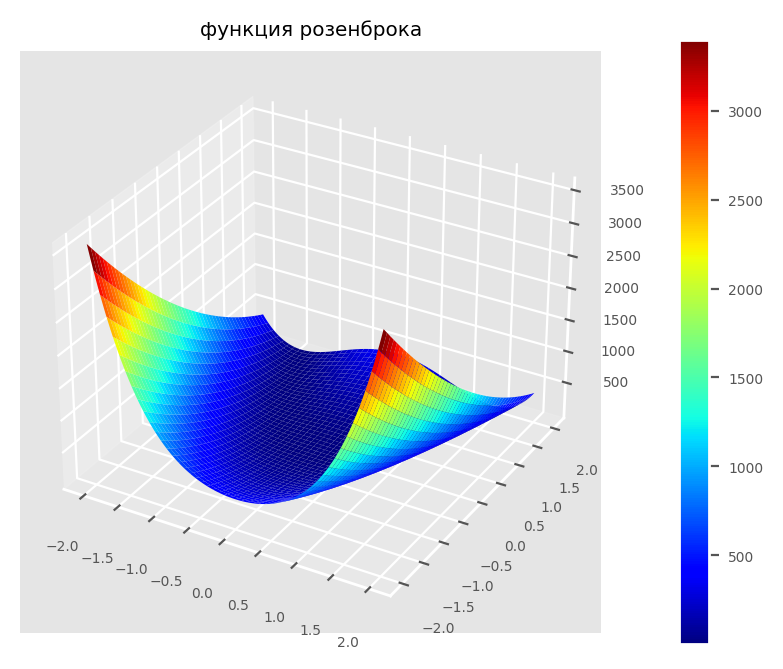

In [7]:
# эта функция используется для бенчмарка методов оптимизации
import functions.RozenbrockBananaFunction as banana

def drawRozenbrock():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf = basic_3d_plot(ax, banana.f, -2, 2, title="функция розенброка")
    fig.colorbar(surf, ax=ax, pad=0.1)
    plt.show()

drawRozenbrock()

result [1. 1.]
last 5 errors: [0.00013952913514341238, 1.864398028206487e-06, 4.436697193262052e-10, 2.6161504958617333e-17, 1.779867417404908e-29]
iterations count 25


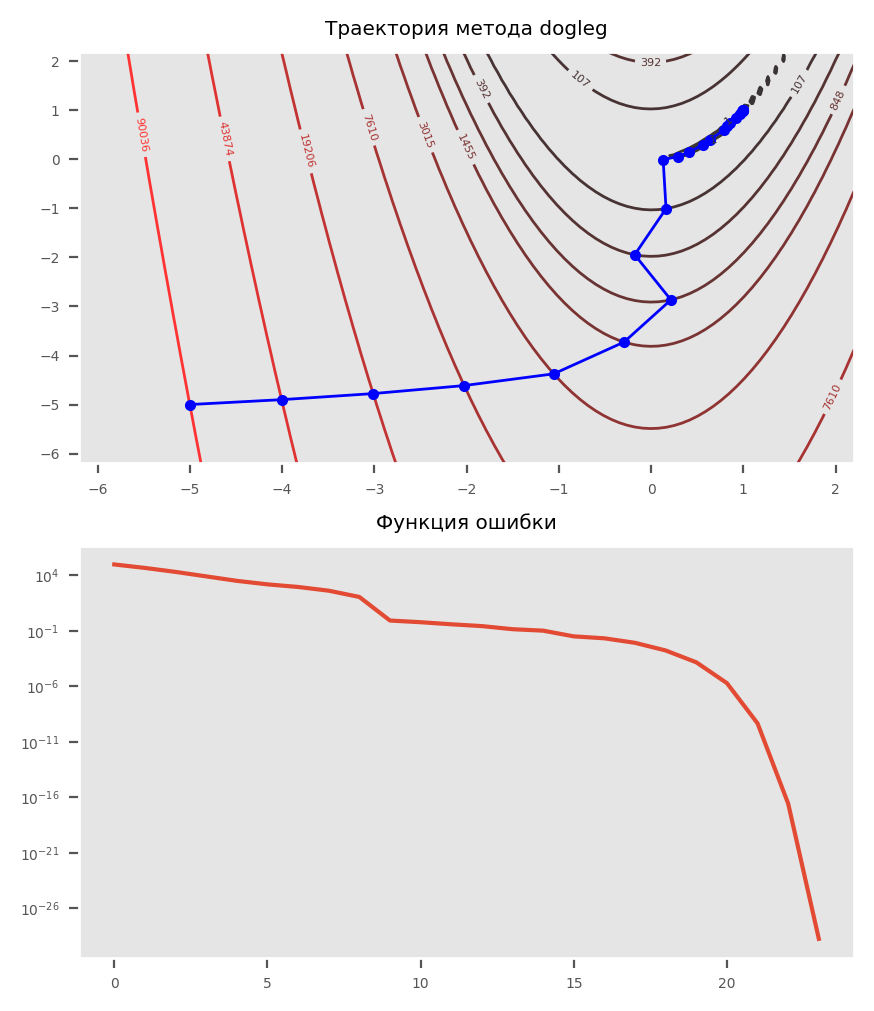

In [8]:
def rozenbrock_approx(mover, c=np.array([-5, -5]), stats=True, points=False):
    regr = regression(mover, c, mover.get_stop_cond())
    if stats:
        print("result", regr[-1])
        print("last 5 errors:", [banana.f(p) for p in regr[-5:]])
        print("iterations count", len(regr) - 1)
    if points:
        return regr


def rozenbrock_check(mover, method_name, c=np.array([-5, -5]), stats=True, points=False):
    regr = rozenbrock_approx(mover, c=c, stats=stats, points=True)

    # избавляемся от повторяющихся точек
    unique_points = []
    counter = set()
    for p in regr:
        if (p[0], p[1]) not in counter:
            counter.add((p[0], p[1]))
            unique_points.append(p)
    
    unique_points = np.array(unique_points)

    if stats:
        # порисуем!
        fig = plt.figure(figsize=(5,6))
        ax1 = fig.add_subplot(2,1,1)
        ax2 = fig.add_subplot(2,1,2)
        plot_contours(ax1, unique_points, banana.f, "метода " + method_name, add_labels=True)
        ax2.plot(list(map(banana.f, unique_points)))
        ax2.set_yscale('log')
        ax2.set_title("Функция ошибки", color='black')
        plt.show()
    if points:
        return regr


def rozenbrock_dogleg():
    return DogLegMover(banana, initial_tr=1, max_tr=1, eta=0.25)


rozenbrock_check(rozenbrock_dogleg(), 'dogleg')

#### Проверка метода на минимизации нелинейной суммы квадратов.

Исходная функция: $0.0005x^5 - 0.4x^4 + 2x^3 + 1x^2 - 10x + 10$

Те же семь точек.

In [9]:
# берем те же polynomial_points

def polynomial_dogleg():
    return DogLegMover(LeastSquaresMethod(polynomial_points, poly), initial_tr=100, eta=1e-10)

polynomial_approx(polynomial_dogleg(), c=np.array([-1, -1, -1, -1, -1, -1]))

result [ 4.97899579e-04 -3.99992891e-01  2.00001921e+00  9.99979189e-01
 -1.00000062e+01  9.99995471e+00]
iterations 2
error 1.6180909275142666e-09


#### Вспомним методы из лабораторной работы 2.

Реализуем модифицированный стохастический градиентный спуск для сравнения с методами Гаусса-Ньютона и DogLeg.

In [10]:
class AdamMover:
    EPS = 1e-10
    m_prev = 0
    v_prev = 0

    def __init__(self, lr, function, b1=0.9, b2=0.999):
        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.function = function

    def __call__(self, x, **kwargs):
        g = self.function.stochastic_grad(x).T[0]
        m_new = self.b1 * self.m_prev + (1 - self.b1) * g
        self.m_prev = m_new

        v_new = self.b2 * self.v_prev + (1 - self.b2) * np.power(g, 2)
        self.v_prev = v_new

        t = kwargs.get("epoch")
        m = m_new / (1 - np.power(self.b1, t))
        v = v_new / (1 - np.power(self.b2, t))

        return x - self.lr * m / (np.sqrt(v) + self.EPS)
    
    def get_stop_cond(self, eps=EPS):
        return XStopCondFactory(eps)

#### Сравнение сходимости методов при аппроксимации полинома

Напоминаем, $0.0005x^5 - 0.4x^4 + 2x^3 + 1x^2 - 10x + 10$

errors [1.618091773539727e-09, 1.6180909275142666e-09, 0.004909524227364067]
iterations [1, 2, 1000]


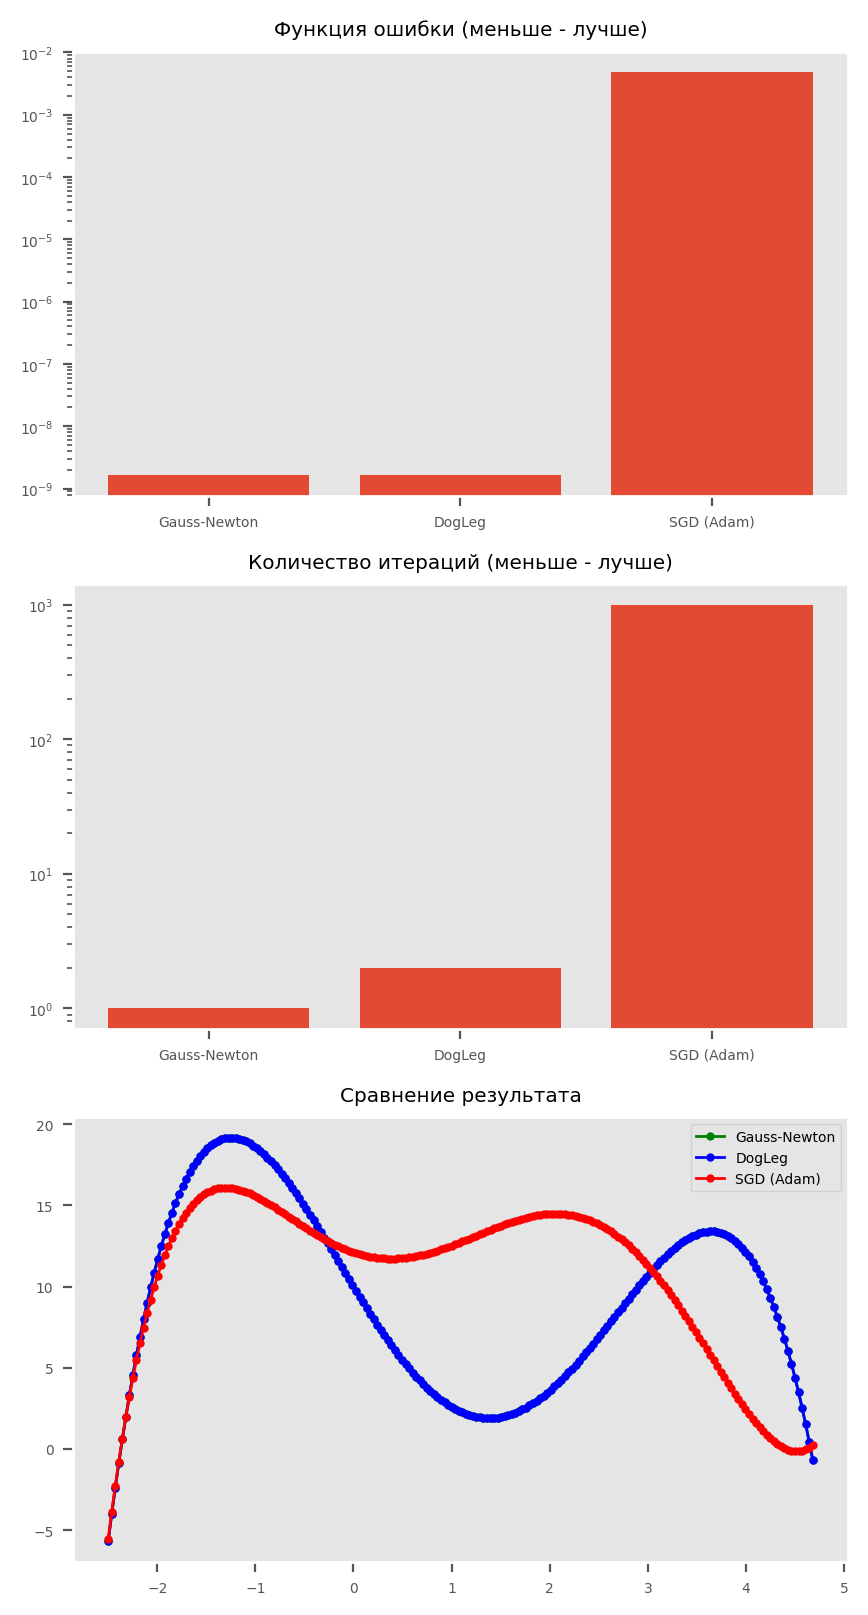

In [11]:
def polynomial_check(methods, titles, colors):
    lsq = LeastSquaresMethod(polynomial_points, poly)
    errors = [lsq(p[-1]) for p in methods]
    iterations = [len(p) - 1 for p in methods]

    print("errors", errors)
    print("iterations", iterations)

    fig = plt.figure(figsize=(5, 10))
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,2)
    ax3 = fig.add_subplot(3,1,3)
    basic_bar_chart(ax1, titles, errors, title="Функция ошибки (меньше - лучше)", log=True)
    basic_bar_chart(ax2, titles, iterations, title="Количество итераций (меньше - лучше)", log=True)
    for i in range(len(methods)):
        basic_2d_plot(ax3, lambda X: [poly.f([x], methods[i][-1]) for x in X], -2.5, 4.68, 200, title="Сравнение результата", color=colors[i])
    ax3.legend(titles, labelcolor="black")
    plt.show()


def polynomial_adam():
    return AdamMover(0.37, LeastSquaresMethod(polynomial_points, poly), b2=0.999)


movers=[polynomial_gn(), polynomial_dogleg(), polynomial_adam()]
c = np.array([-1, -1, -1, -1, -1, -1])
methods = [polynomial_approx(mover, c=c, stats=False, points=True) for mover in movers]

polynomial_check(
    methods,
    ["Gauss-Newton", "DogLeg", "SGD (Adam)"],
    ['g', 'b', 'r']
)

### 2. Реализовать метод BFGS и исследовать его сходимость при минимизации различных функций
Сравнить с другими реализованными методами.

### Метод BFGS, теория.

Окей, BFGS - это наиболее популярный квазиньютоновский метод. Он опирается на алгоритм Ньютона, но для вычисления гессиана использует аппроксимации. Например, метод Гаусс-Ньютона выкидывал вторые производные, а BFGS будет их каким-то образом приближать.

Квадратичная модель - все та же.

$m_k(p) = f(x_k) + \nabla f(x_k)^T p + \frac{1}{2} \cdot p^T H p$

Направление минимизации по Ньютону по-прежнему равно $\displaystyle p_k = - \frac{\nabla f_k}{H}$

Люди думали-думали и придумали условие аппроксимации гессиана, но писать его я не буду, так как в лекции оно озвучивалось для метода DFP. В методе BFGS вообще гессиан не ищут, а ищут обратный гессиан (посмотри на строчку выше и пойми зачем нужен именно обратный. ну типа зачем искать гессиан, если его все равно нужно будет за дорого обращать? давайте сразу обратный искать - во!).

Давайте запишем просто, что мы хотим, и как будем этого добиваться.

#### Пересчет обратного гессиана

Наш обратный гессиан должен подчиняться следующему равенству:

$\displaystyle H_{k+1}^{-1} \cdot y_k = s_k$,

где $y_k = \nabla f_{k+1} - \nabla f_k, \; s_k = \alpha_k p_k = x_{k+1} - x_k$

Притом из всех таких гессианов наш следующий кандидат должен минимально отличаться от предыдущего:

$\displaystyle H_{k+1}^{-1} = \argmin_{H^{-1}}(\| H^{-1} - H_k^{-1} \|)$,

где $H^{-1} = H^{-T}$ (симметричность) и $H^{-1} \cdot y_k = s_k$

И вот гении придумали пересчет обратного гессиана делать так:

$\displaystyle H_{k+1} = (I - p_k \cdot s_k \cdot y_k^T) \cdot H_k \cdot (I - p_k \cdot y_k \cdot s_k^T) + p_k \cdot s_k \cdot s_k^T$,

где $\displaystyle p_k = \frac{1}{y_k^T \cdot s_k}$

~~_страшно?_~~

Так, ну, здорово, умеем считать обратный гессиан. Дальше просто, как мы уже сказали...

#### Делаем шаг

Забавно, что эти две формулы прячут под коврик страшную жесть.

$\displaystyle p_k = -H_k^{-1} p_k$

$x_{k+1} = x_k - \alpha_k p_k$

Но здесь есть одно но! Халява закончилась и $\alpha$ надо искать одномерным поиском (линейный поиск, бинпоиск, и т.д), причем с обязательным соблюдением условий Вольфе (они вообще пришли из BFGS, насколько я помню), иначе если наш гессиан потеряет положительную определенность, метод сломается (откуда она там есть, я не помню). Как и ранее, в условиях Вольфе предлагается использовать константы $c_2 = 0.9, \; c_1 = 10^{-4}$

Теперь второе но, которое вновь оказалось под ковриком.

#### Как искать первый обратный гессиан?

Можно по-честному найти гессиан функции в начальной точке и обратить его.

Либо взять диагональную матрицу, умноженную на какой-нибудь скаляр, и молиться, что оно сойдется.

$H_0 = \beta \cdot I$

Наконец, если параметров много и обратный гессиан хранить очень накладно или если матрица разрежена _(вот в этом не уверен, из головы взял)_, то можно использовать метод L-BFGS, о котором расскажут в задании 3.


In [12]:
# для отладки linsearch.py
# import importlib, utils.linsearch
# importlib.reload(utils.linsearch)

from utils.linsearch import *
import traceback

# код для метода BFGS

class BFGSMover:
    function = None
    hinv = None
    lr_policy = None
    c1 = None
    c2 = None
    beta = None
    prev_g = None
    debug = False

    def __init__(self, function, lr_policy, beta=1, hinv=None, c1=1e-4, c2=0.9, debug=False):
        self.function = function
        self.lr_policy = lr_policy
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.hinv = hinv
        self.debug = debug
    
    def setup(self, dim):
        self.hinv = self.beta * np.eye(dim)
    
    def update_hinv(self, s, y):
        p = 1 / np.matmul(y.T, s)
        a = p * np.matmul(s, y.T)
        b = p * np.matmul(y, s.T)
        c = p * np.matmul(s, s.T)
        i = np.eye(len(s))
        self.hinv = np.matmul((i - a), np.matmul(self.hinv, (i - b))) + c
    
    def __call__(self, x, **kwargs):
        if self.hinv is None:
            self.setup(len(x))
        
        g = self.function.grad(x)
        p = -np.matmul(self.hinv, g)
        try:
            x_new = self.lr_policy(self.function.f, self.function.grad, x, p, self.c1, self.c2)
        except Exception as e:
            if self.debug:
                print(traceback.format_exc()) #  не смогли обновиться
            self.prev_g = np.zeros(len(g))
            return x
        
        y = self.function.grad(x_new) - g
        s = (x_new - x).reshape(-1, 1)
        self.prev_g = g

        self.update_hinv(s, y)
        return x_new

    def get_stop_cond(self, eps=EPS):
        return lambda **kwargs: self.prev_g is not None and np.linalg.norm(self.prev_g) < eps


#### Проверка метода BFGS на аппроксимации параболы

original: $0.005x^2 + 0.5x + 10$

In [13]:
# используем те же parabola_points

def parabola_bfgs(c=np.array([-1, -1, -1])):
    f = LeastSquaresMethod(parabola_points, poly)
    search = Linsearch(max_lr=1.2, step=0.1)
    h = np.linalg.inv(f.hessian(c))
    return BFGSMover(f, search, hinv=h)

parabola_approx(parabola_bfgs(), c=np.array([-1, -1, -1]))

result [5.e-03 5.e-01 1.e+01]
iterations 14
error 1.2129525278678278e-26


#### Проверка метода на функции Розенброка

result [0.99999959 0.99999913]
last 5 errors: [9.608922029440079e-08, 1.907514582888314e-09, 1.6034447177132347e-10, 4.8050532124715974e-12, 4.5230874361520515e-13]
iterations count 22


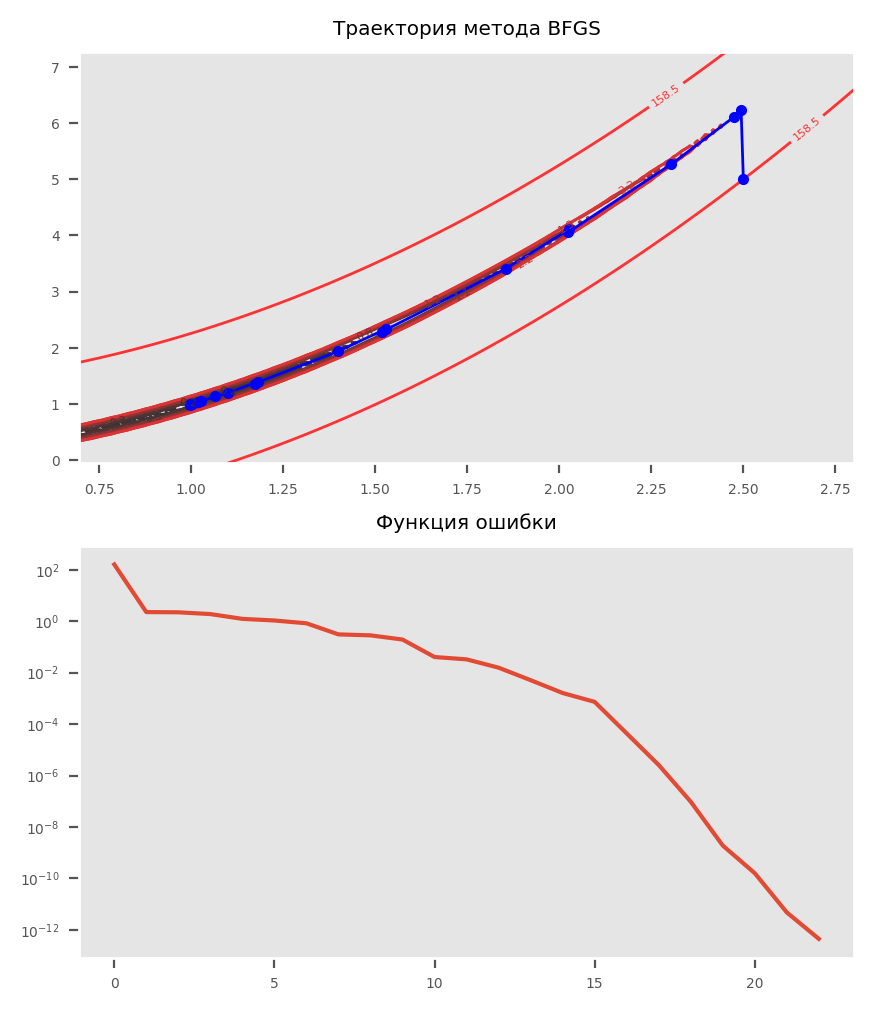

In [14]:
def rozenbrock_bfgs(c=np.array([2.5, 5])):
    search = Linsearch(max_lr=15, step=0.005)
    h = np.linalg.inv(banana.hessian(c))
    return BFGSMover(banana, search, hinv=h, debug=True, c1=0.000001, c2=0.2)

rozenbrock_check(rozenbrock_bfgs(), "BFGS", np.array([2.5, 5]))

#### Сравнение рассмотренных методов на аппроксимации полинома 5 степени

original: $0.0005x^5 - 0.4x^4 + 2x^3 + 1x^2 - 10x + 10$

errors [1.618091773539727e-09, 1.6180909275142666e-09, 7.774937247182051e-10, 0.004909524227364067]
iterations [1, 2, 8, 1000]


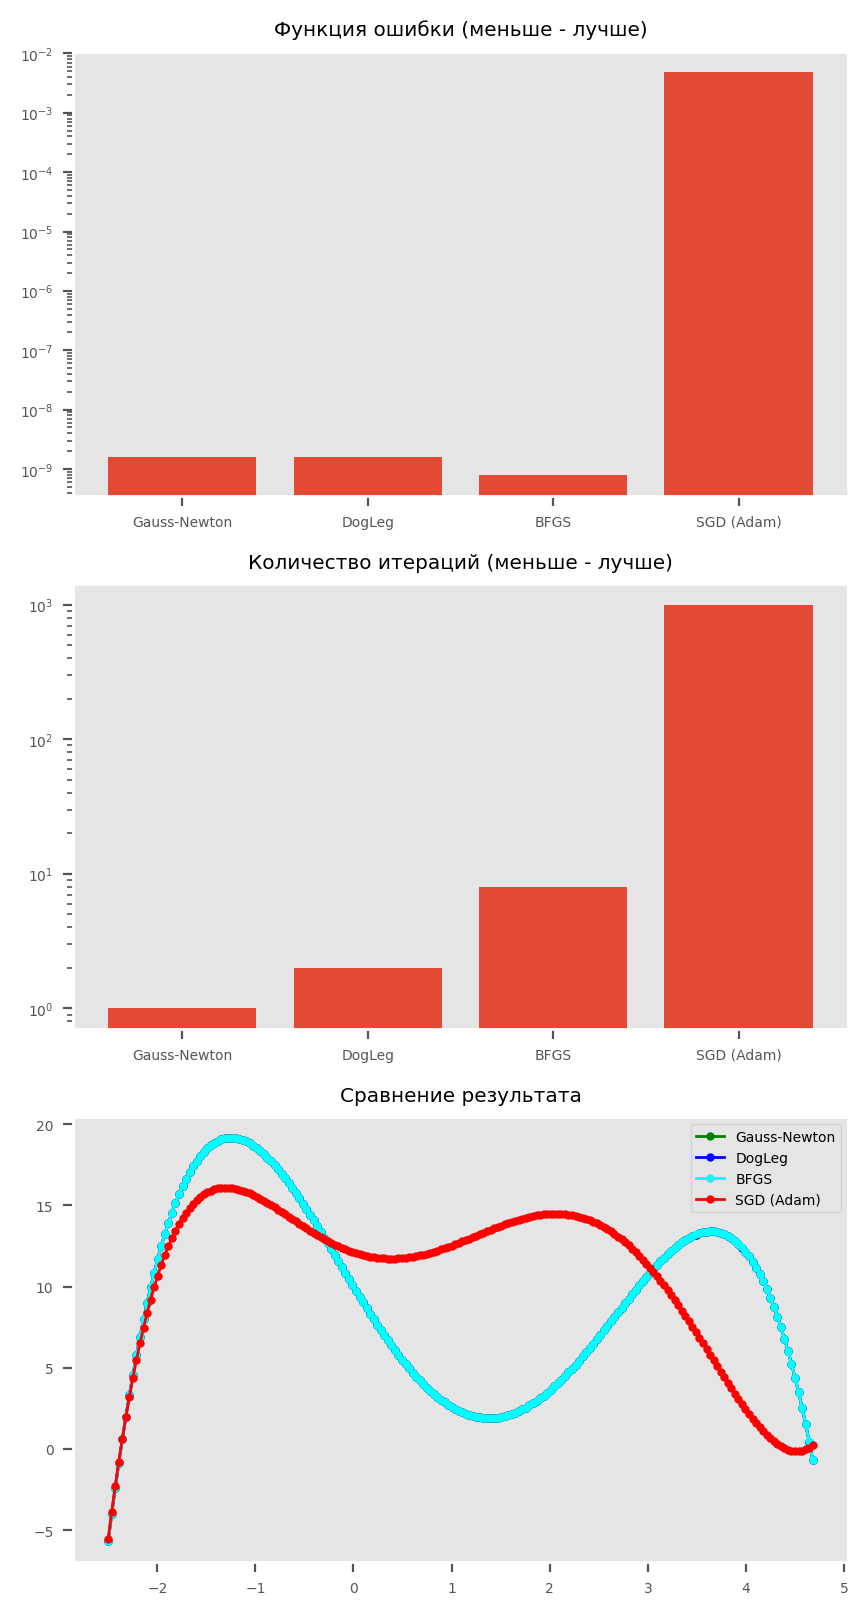

In [15]:
def polynomial_bfgs(c=np.array([-1, -1, -1, -1, -1, -1])):
    f = LeastSquaresMethod(polynomial_points, poly)
    search = Linsearch(max_lr=2, step=0.1)
    h = np.linalg.inv(f.hessian(c))
    return BFGSMover(f, search, hinv=h)


movers=[polynomial_gn(), polynomial_dogleg(), polynomial_bfgs(), polynomial_adam()]
c = np.array([-1, -1, -1, -1, -1, -1])
methods = [polynomial_approx(mover, c=c, stats=False, points=True) for mover in movers]

polynomial_check(
    methods,
    ["Gauss-Newton", "DogLeg", "BFGS", "SGD (Adam)"],
    ['g', 'b', 'cyan', 'r']
)

И снова успех. Коэффициенты снова найдены достаточно точно (учитывая что алгоритм учитывал всего 7 точек)
(первые три совпали, а Adam все так же отличается)

##### Круто! :)

Вывод: БФГС - мощный алгоритм, причем более универсальный (в отличие от Гаусс-Ньютона который подходит только для решения регрессий) 
Он сходится за несколько большее количество итераций чем DogLeg или G-N. Однако важно учесть, что в отличие от DogLeg он assимтотически быстрее $O(n^2)$ против $O(n^3)$ на итерацию (от кол-ва аргументов функции) $=>$ он способен находить минимумы функций которые DogLeg не сможет из-за ограничений железа

In [16]:
rosenbrock = lambda x: (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2
rosenbrock_grad = lambda x: np.asarray([-400 * (x[1] - x[0] ** 2) * x[0] - 2 + 2 * x[0], 200 * x[1] - 200 * x[0] ** 2])

### Задание 3. Реализовать и исследовать метод L-BFGS

Еще раз, псевдокод BFGS:

$\displaystyle while ({\| \nabla f \|} > \epsilon):$

1) $\displaystyle p_{k} = - H_{k} \cdot \nabla f_{k} $, где $H_{k}$ - аппроксимация обратной матрицы Гессиана
2) $\displaystyle x_{k+1} = x_{k} + \alpha_k * p_{k} $, где $\alpha_k$ находится линейным поиском с соблюдением условия Вольфе
3) $\displaystyle y_k = \nabla f_{k+1} - \nabla f_k $
4) $\displaystyle s_k = \alpha_k p_k = x_{k+1} - x_k$
5) $\displaystyle H_{k+1} = (I - \rho_k \cdot s_k \cdot y_k^T) \cdot H_k \cdot (I - \rho_k \cdot y_k \cdot s_k^T) + \rho_k \cdot s_k \cdot s_k^T$, где $\displaystyle \rho_k = \frac{1}{y_k^T \cdot s_k}$

Если матрица $H_{k}$ очень большая (например, когда аппроксимируем полином очень большой степени), ее затратно и иногда даже невозможно хранить в памяти.

Для решения этой проблемы создан метод L-BFGS, который вместо матрицы n*n хранит историю из нескольких последних (скажем, с последних m итераций) пар векторов: ` {s_{i}, y_{i}} for i=k-m, ..., k-1` (k - номер текущей итерации), по которым происходит неточное восстановление матрицы. Для этого после каждой итерации будем удалять из очереди истории самую древнюю пару и помещать в голову полученную на текущей итерации пару {$s_{k}$, $y_{k}$}.

Обычно m выбирается небольшим, между 3 и 20.

Для удобства запишем формулу из 5 шага алгоритма BFGS в виде:
$\displaystyle H_{k+1} = V_k^T \cdot H_{k} \cdot V_{k} + \rho_k \cdot s_k \cdot s_k^T$, где $V_{k} = I - \rho_k \cdot y_k \cdot s_k^T$

На k-ой итерации будем аппроксимировать матрицу $H_{k}$ следующей формулой (получается рекурсивной подстановкой):

$\displaystyle H_{k} = (V_{k-1}^T...V_{k-m}^T) \cdot H_k^0 \cdot (V_{k-m}...V_{k-1}) \\ + \rho_{k-m} \cdot (V_{k-1}^T...V_{k-m+1}^T) \cdot s_{k-m} \cdot s_{k-m}^T \cdot (V_{k-m+1}...V_{k-1}) \\ + \rho_{k-m+1} \cdot (V_{k-1}^T...V_{k-m+2}^T) \cdot s_{k-m+1} \cdot s_{k-m+1}^T \cdot (V_{k-m+2}...V_{k-1}) \\ + ... +  \rho_{k-1} \cdot s_{k-1} \cdot s_{k-1}^T$

Выберем $\displaystyle H_k^0 = \frac{s_{k-1}^T \cdot y_{k-1}}{y_{k-1}^T \cdot y_{k-1} + \epsilon}$

Напишем функцию, которая будет вычислять направление спуска $ - H_{k} \cdot \nabla f_{k} $:

In [17]:
from collections import deque

class MyQueue:
    def __init__(self, m):
        self.m = m  # размер истории
        self.queue = deque()

    def add(self, v: np.array):
        self.queue.append(v)
        if len(self.queue) > self.m:
            self.queue.popleft()

    def get(self):
        return self.queue

    def __getitem__(self, ind: int):
        return self.queue[ind]

    def size(self):
        return len(self.queue)

In [18]:
class LBFGSHistory:
    s = None
    y = None
    rho = None

    def __init__(self, m=3):
        self.s = MyQueue(m)
        self.y = MyQueue(m)
        self.rho = MyQueue(m)

    def update(self, x_new, x, g_new, g):
        delta_x = x_new - x
        delta_g = g_new - g
        self.s.add(delta_x)
        self.y.add(delta_g)
        self.rho.add(1. / (np.dot(delta_g, delta_x) + 1e-30))

In [19]:
def calculate_direction(grad, history: LBFGSHistory, h_init):
    q = np.copy(grad)
    m = history.rho.size()
    alpha = np.zeros(m)

    for i in range(m - 1, -1, -1):
        alpha[i] = history.rho[i] * np.dot(history.s[i], q)
        q = q - alpha[i] * history.y[i]

    if m == 0:
        H_init = h_init
        if isinstance(h_init, np.ndarray):
            r = np.matmul(H_init, q.reshape(-1, 1)).T[0]
        else:
            r = H_init * q
    else:
        H_init = np.dot(history.s[-1], history.y[-1]) / (np.dot(history.y[-1], history.y[-1]) + 1e-30)
        r = H_init * q

    for i in range(m):
        beta = history.rho[i] * np.dot(history.y[i], r)
        r = r + history.s[i] * (alpha[i] - beta)

    return -r

#### Итак, псевдокод для алгоритма L-BFGS:


$\displaystyle while ({\| \nabla f \|} > \epsilon):$

1) $\displaystyle p_{k} = calculate\_direction(s, y, grad, rho) $
2) $\displaystyle x_{k+1} = x_{k} + \alpha_k * p_{k} $, где $\alpha_k$ находится линейным поиском с соблюдением условия Вольфе
3) $y_k = \nabla f_{k+1} - \nabla f_k $
4) $s_k = \alpha_k p_k = x_{k+1} - x_k$
5) $s.add(s_k), y.add(y_k)$

In [20]:
#import importlib, utils.linsearch
#importlib.reload(utils.linsearch)

def lbfgs(f, x0, grad, m: int = 3, eps: float = 1e-9, max_iterations=100, h_init=1, b1=1e-4, b2=0.9, search=None):
    x = np.copy(x0)
    points_history = [x]
    g = grad(x)
    history = LBFGSHistory(m)
    epoch = 0

    while np.linalg.norm(g) > eps and epoch <= max_iterations:
        d = calculate_direction(g, history, h_init=h_init)
        try:
            x_new = search(f, lambda x: grad(x).reshape(-1, 1), x, d.reshape(-1, 1), c1=b1, c2=b2)
        except Exception as e:
            print("search stopped")
            break
        
        g_new = grad(x_new)

        history.update(x_new, x, g_new, g)

        x = x_new
        g = g_new

        points_history.append(x_new)

        epoch += 1

    return points_history

#### Тестируем

In [21]:
def plot_trajectory_and_contours(points, f, plot=False):
    print(points[-1], len(points), f(points[-1]))

    if plot:
        print("result", points[-1])
        print("last 5 errors:", [f(p) for p in points[-5:]])
        print("iterations count", len(points) - 1)
        fig = plt.figure(figsize=(5, 6))
        ax1 = fig.add_subplot(2, 1, 1)
        ax2 = fig.add_subplot(2, 1, 2)
        plot_contours(ax1, np.array(points), f, "метода LBFGS", add_labels=True)
        ax2.plot(list(map(f, points)))
        ax2.set_yscale('log')
        ax2.set_title("Функция ошибки", color='black')
        plt.show()

[1. 1.] 58 8.473397503139023e-20
result [1. 1.]
last 5 errors: [8.710278829504764e-18, 2.177542600939219e-18, 5.443857788191169e-19, 1.3635403613030673e-19, 8.473397503139023e-20]
iterations count 57


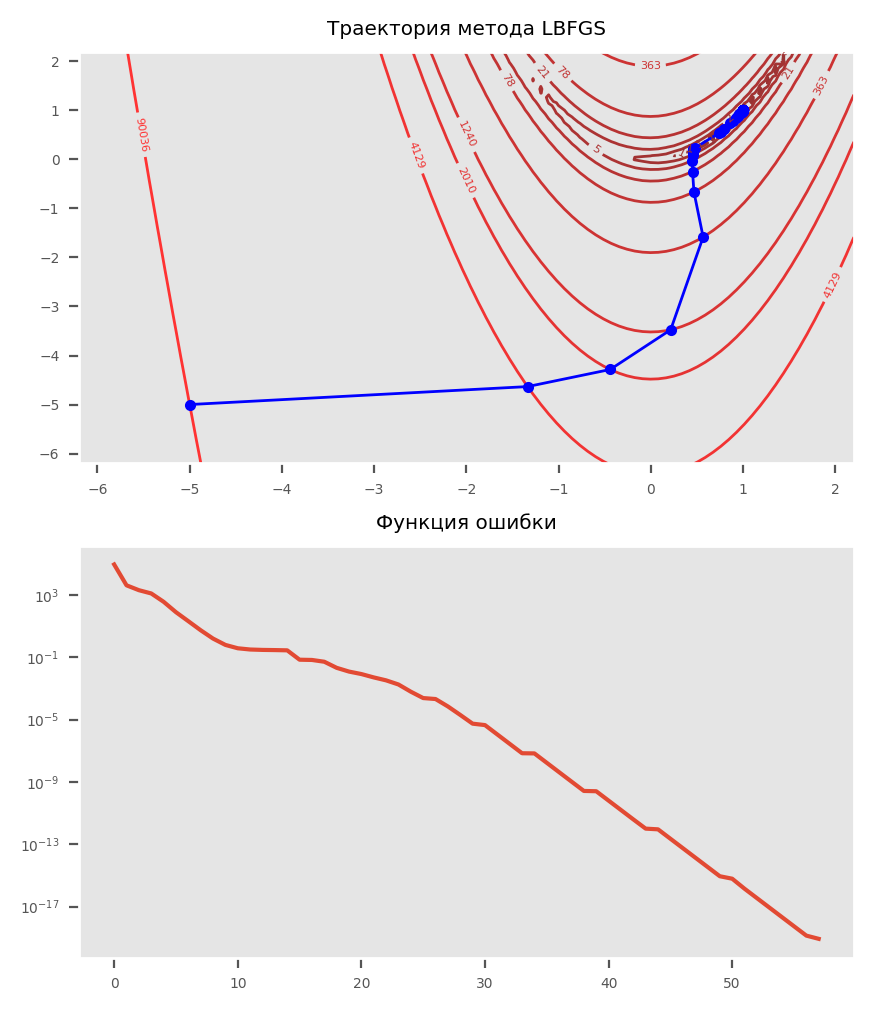

In [22]:
points = lbfgs(rosenbrock, np.array([-5., -5.]), rosenbrock_grad, m=3, search=line_search)
plot_trajectory_and_contours(points, rosenbrock, plot=True)

[1. 1.] 67 9.00935452600764e-21
result [1. 1.]
last 5 errors: [1.0177088260156063e-18, 1.7977523842076042e-19, 4.2490954330240774e-20, 1.0619839393107407e-20, 9.00935452600764e-21]
iterations count 66


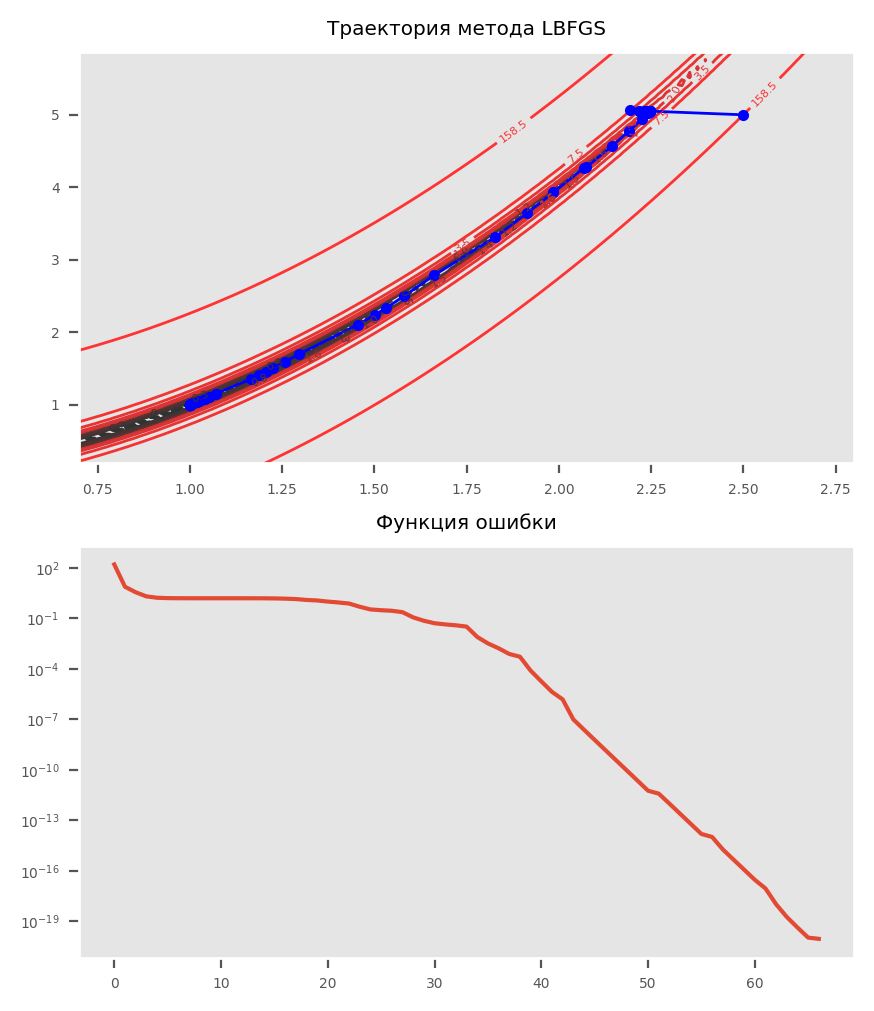

In [23]:
points = lbfgs(rosenbrock, np.array([2.5, 5]), rosenbrock_grad, m=3, search=line_search)
plot_trajectory_and_contours(points, rosenbrock, plot=True)

Теперь попробуем аппроксимировать параболу

In [24]:
def parabola_approx_comp(mover, stats=True, points=False):
    c = np.array([-1, -1, -1])
    
    search = Linsearch(max_lr=1.2, step=0.1)
    regr = lbfgs(mover.f, c, mover.grad, m=3, h_init=np.linalg.inv(mover.hessian(c)), b1=0.0001, b2=0.1, search=search)
    if stats:
        print("result", regr[-1])
        print("iterations", len(regr) - 1)
        print("error", mover.f(regr[-1]))
    if points:
        return regr

class LeastSquaresMethodWrapper(LeastSquaresMethod):
    def grad(self, c):
        return super().grad(c).T[0]

parabola_approx_comp(LeastSquaresMethodWrapper(parabola_points, poly))

search stopped
result [5.e-03 5.e-01 1.e+01]
iterations 13
error 6.39853284378177e-24


search stopped
errors [1.618091773539727e-09, 1.6180909275142666e-09, 7.774937247182051e-10, 7.774937464128613e-10, 0.004909524227364067]
iterations [1, 2, 8, 7, 1000]


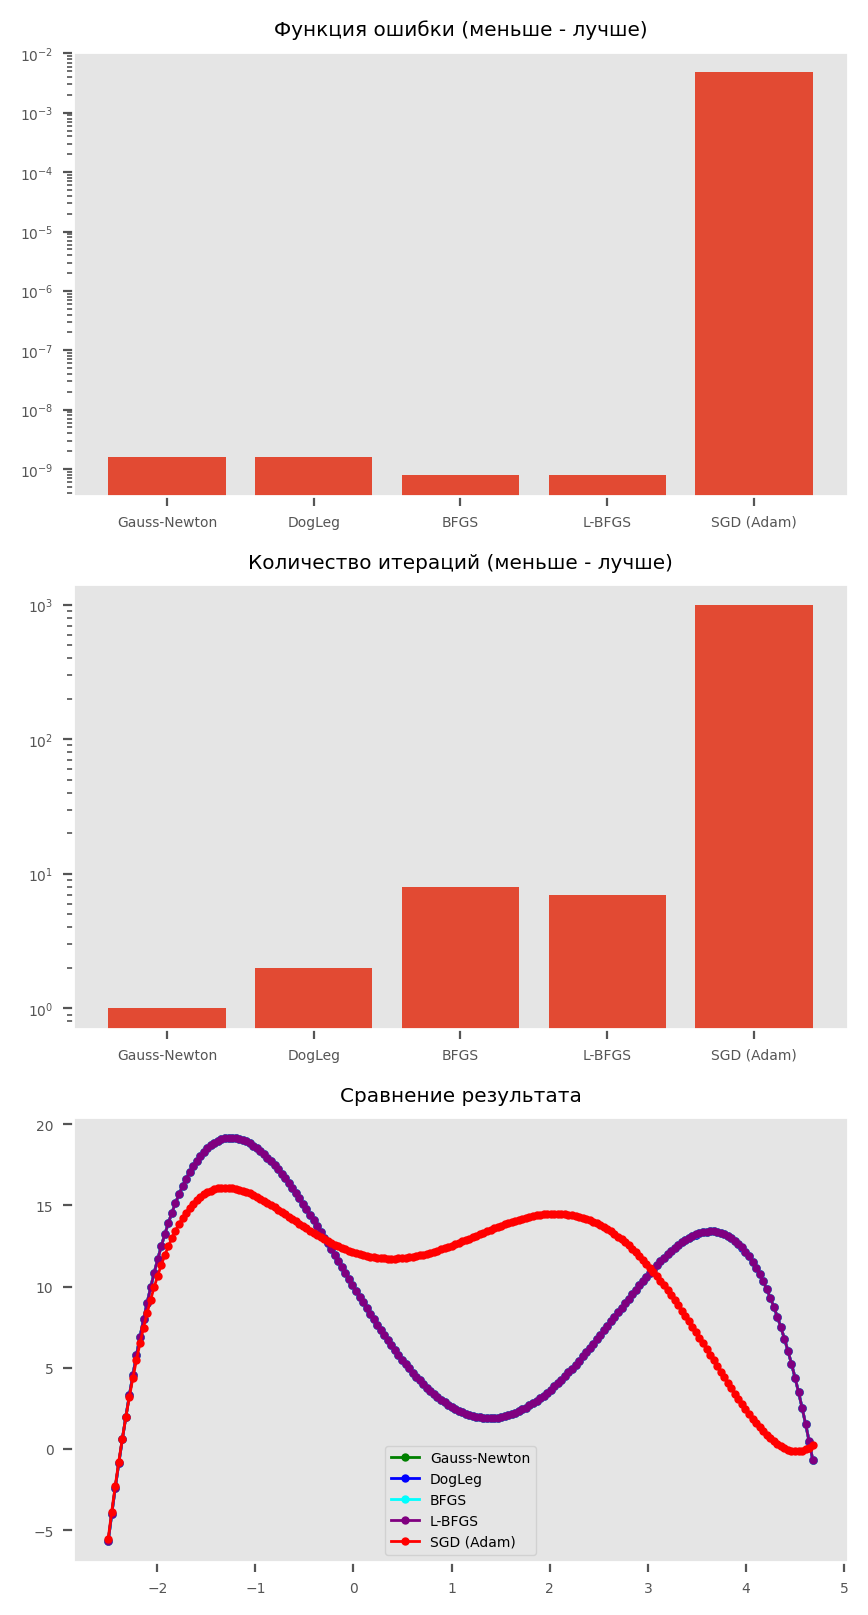

In [25]:

def polynomial_lbfgs(c=np.array([-1, -1, -1, -1, -1, -1])):
    f = LeastSquaresMethodWrapper(polynomial_points, poly)
    search = Linsearch(max_lr=2, step=0.1)
    regr = lbfgs(f.f, c, f.grad, m=3, h_init=np.linalg.inv(f.hessian(c)), b1=0.0001, b2=0.1, search=search)
    return regr


regr = polynomial_lbfgs()

movers=[polynomial_gn(), polynomial_dogleg(), polynomial_bfgs(), polynomial_adam()]
c = np.array([-1, -1, -1, -1, -1, -1])
methods = [polynomial_approx(mover, c=c, stats=False, points=True) for mover in movers]
methods.insert(3, regr)

polynomial_check(
    methods,
    ["Gauss-Newton", "DogLeg", "BFGS", "L-BFGS", "SGD (Adam)"],
    ['g', 'b', 'cyan', 'purple', 'r']
)

При сравнении четырех методов все показали себя хорошо. Про потребление ресурсов стоит сказать отдельно:

Если DogLeg тратит $O(n^3)$ времени на каждую итерацию, то метод BFGS тратит $O(n^2)$ времени, а L-BFGS - $O(n \cdot m)$, где m - количество хранимых итераций.

В таком случае, DogLeg пусть и использует более точные вычисления, но его затруднительно использовать на больших задачах. С другой стороны, BFGS и L-BFGS позволяют делать меньше вычислений (а последний и еще меньше памяти потребляет, чем первый, то есть L-BFGS позволяет решать большие задачи засчет такого преимущества), но могут накапливать ошибку арифметики и давать менее точный результат.

Метод Гаусса-Ньютона в сторонке из-за применимости только в минимизации квадратов. Его целесообразно применять, когда количество параметров невелико, а желаемая точность высока.